<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



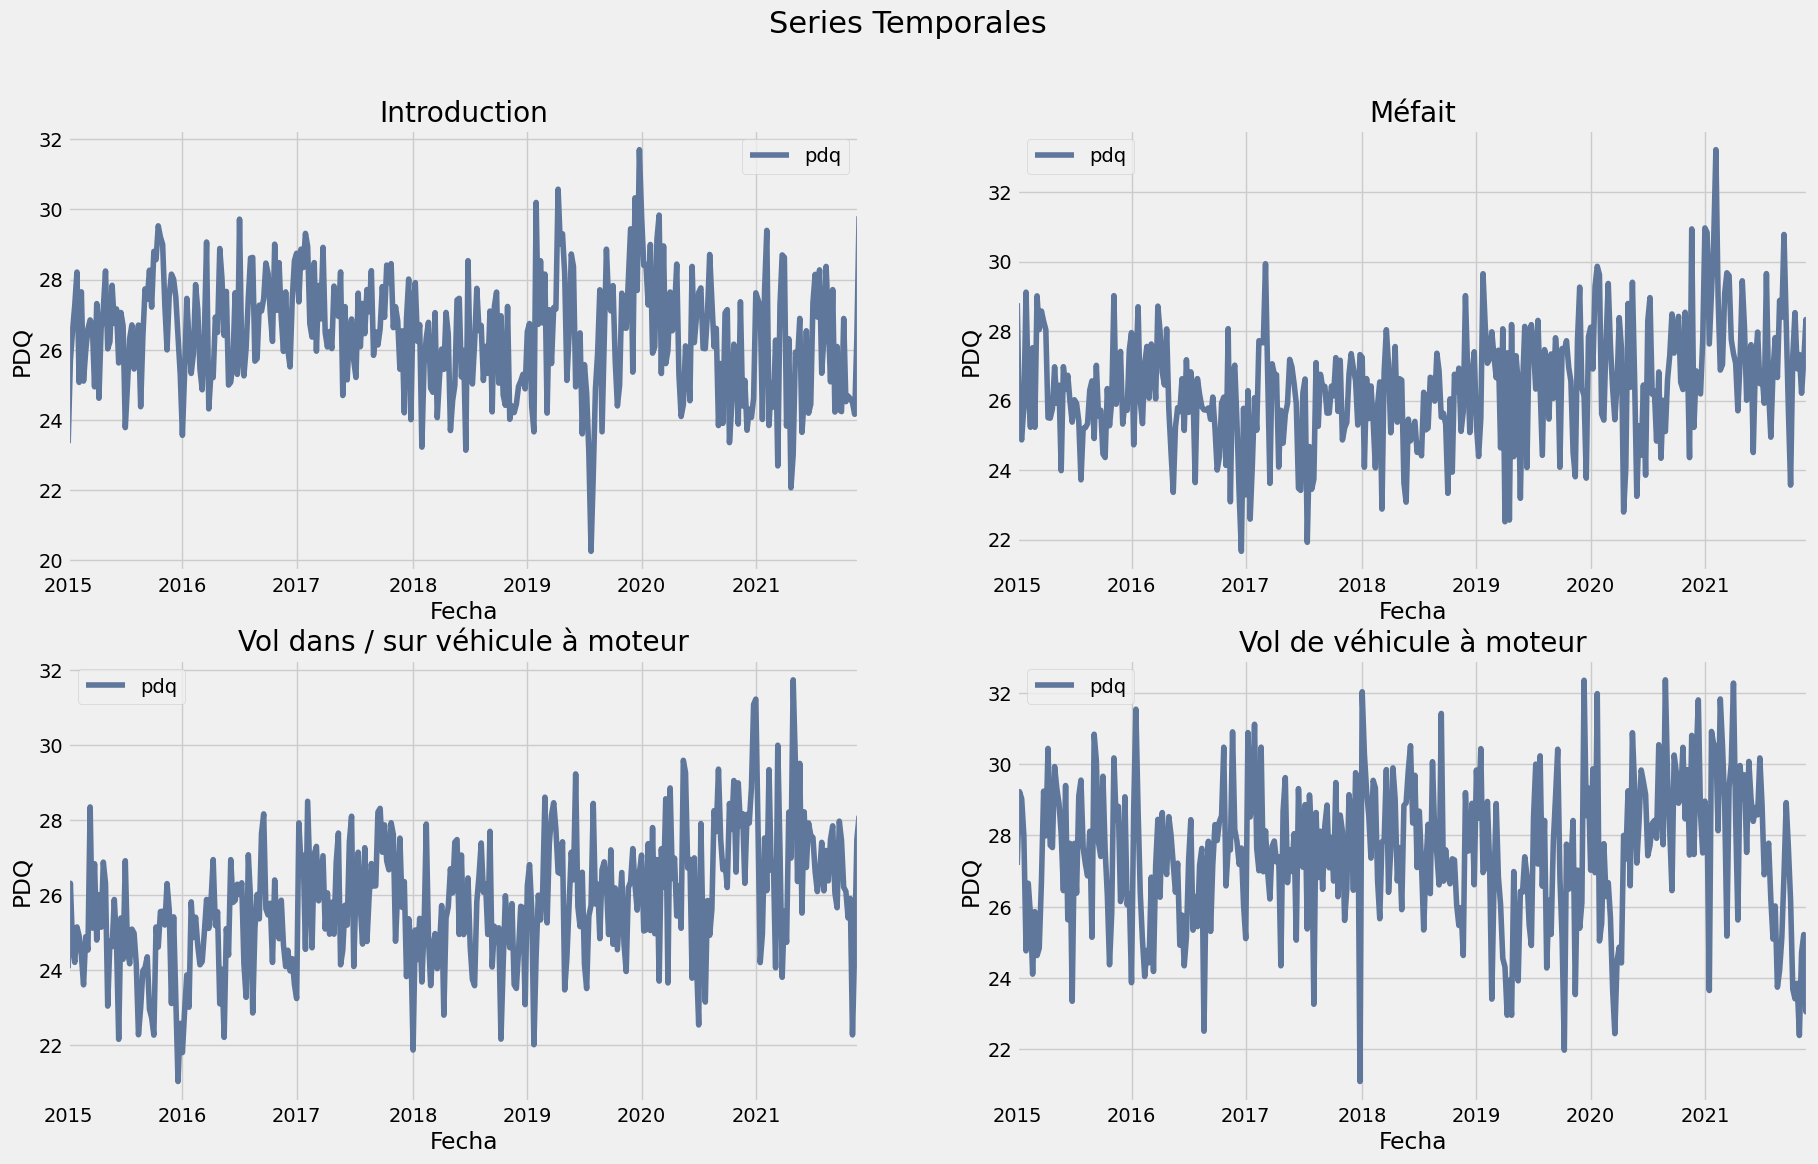

In [5]:
lista= [y_s1, y_s2, y_s3, y_s4]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Series Temporales', fontsize=22)

for (serie, titulo, ax) in zip(lista, validate_categorie, axes.flatten()):
    serie.plot(ax=ax, title=titulo)
    ax.set_ylabel('PDQ')
    ax.set_xlabel('Fecha')
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

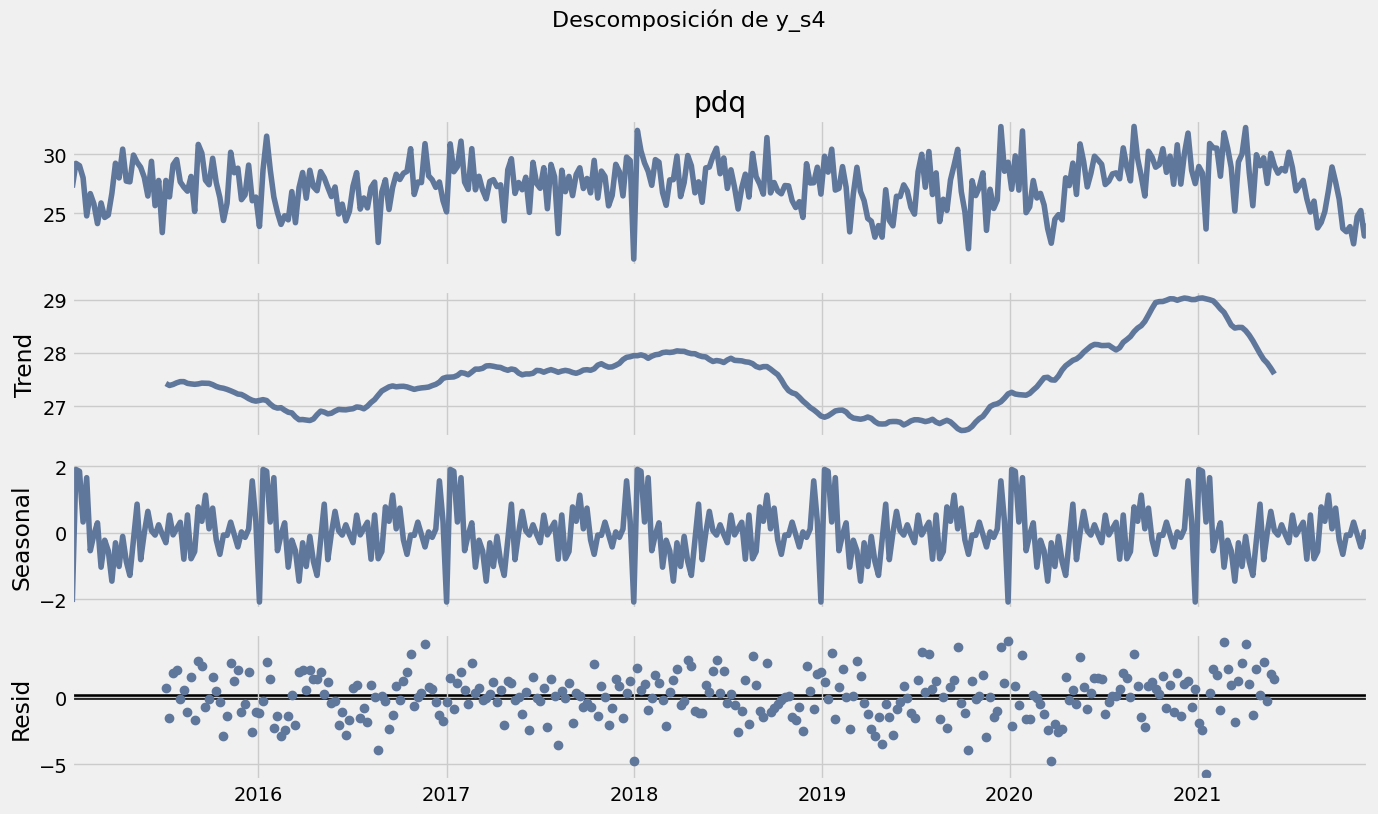

In [7]:
#Análisis exploratorio:
decomposition = sm.tsa.seasonal_decompose(y_s4['pdq'], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Descomposición de y_s4', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Es claro por los graficos anteriores, que no hay una tendencia lineal clara, por otro lado, hay un patron en el grafico estacional, este puede indicar que hay mas robos de vehiculos en ciertas estaciones del año que en otras.

In [8]:
#Modelado con SARIMA:

import itertools
import warnings
from tqdm import tqdm

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
params = list(itertools.product(pdq, seasonal_pdq))
target_date = '2021-01-01'

print(f"Total de modelos a probar: {len(params)}")

all_metrics = []

for param in tqdm(params):
    try:
        model = SarimaModels(params=param)

        df_metrics = model.metrics(y=y_s4, date=target_date)
        all_metrics.append(df_metrics)

    except Exception as e:
        continue

df_all_metrics = pd.concat(all_metrics).reset_index(drop=True)
df_all_metrics_sorted = df_all_metrics.sort_values('rmse')

print("\n--- Mejores Modelos (ordenados por RMSE) ---")
print(df_all_metrics_sorted.head())


Total de modelos a probar: 64


100%|██████████| 64/64 [04:23<00:00,  4.11s/it]


--- Mejores Modelos (ordenados por RMSE) ---
       mae     mse    rmse    mape   maape   wmape   mmape   smape  \
16  2.2015  6.5754  2.5642  0.0826  0.0821  0.0803  0.0795  0.0810   
48  2.1832  6.7815  2.6041  0.0830  0.0825  0.0796  0.0799  0.0803   
20  2.2798  7.0006  2.6459  0.0850  0.0846  0.0832  0.0820  0.0839   
17  2.2858  7.0275  2.6509  0.0853  0.0848  0.0834  0.0822  0.0841   
21  2.2867  7.0340  2.6522  0.0853  0.0848  0.0834  0.0822  0.0841   

                        model  
16  SARIMA_(0,1,0)X(0,0,0,52)  
48  SARIMA_(1,1,0)X(0,0,0,52)  
20  SARIMA_(0,1,0)X(1,0,0,52)  
17  SARIMA_(0,1,0)X(0,0,1,52)  
21  SARIMA_(0,1,0)X(1,0,1,52)  


**La mejor configuracion es SARIMA_(0,1,0)X(0,0,0,52)**, pues **tiene el rmse mas bajo** en comparacion a las demas configuraciones, **con un rmse de $2.5642$**, sin embargo la configuracion SARIMA_(1,1,0)X(0,0,0,52), tiene un rmse $2.6041$, el cual tambien es bajo, con una diferencia de $0.1$ aproximadamente con la mejor configuracion.

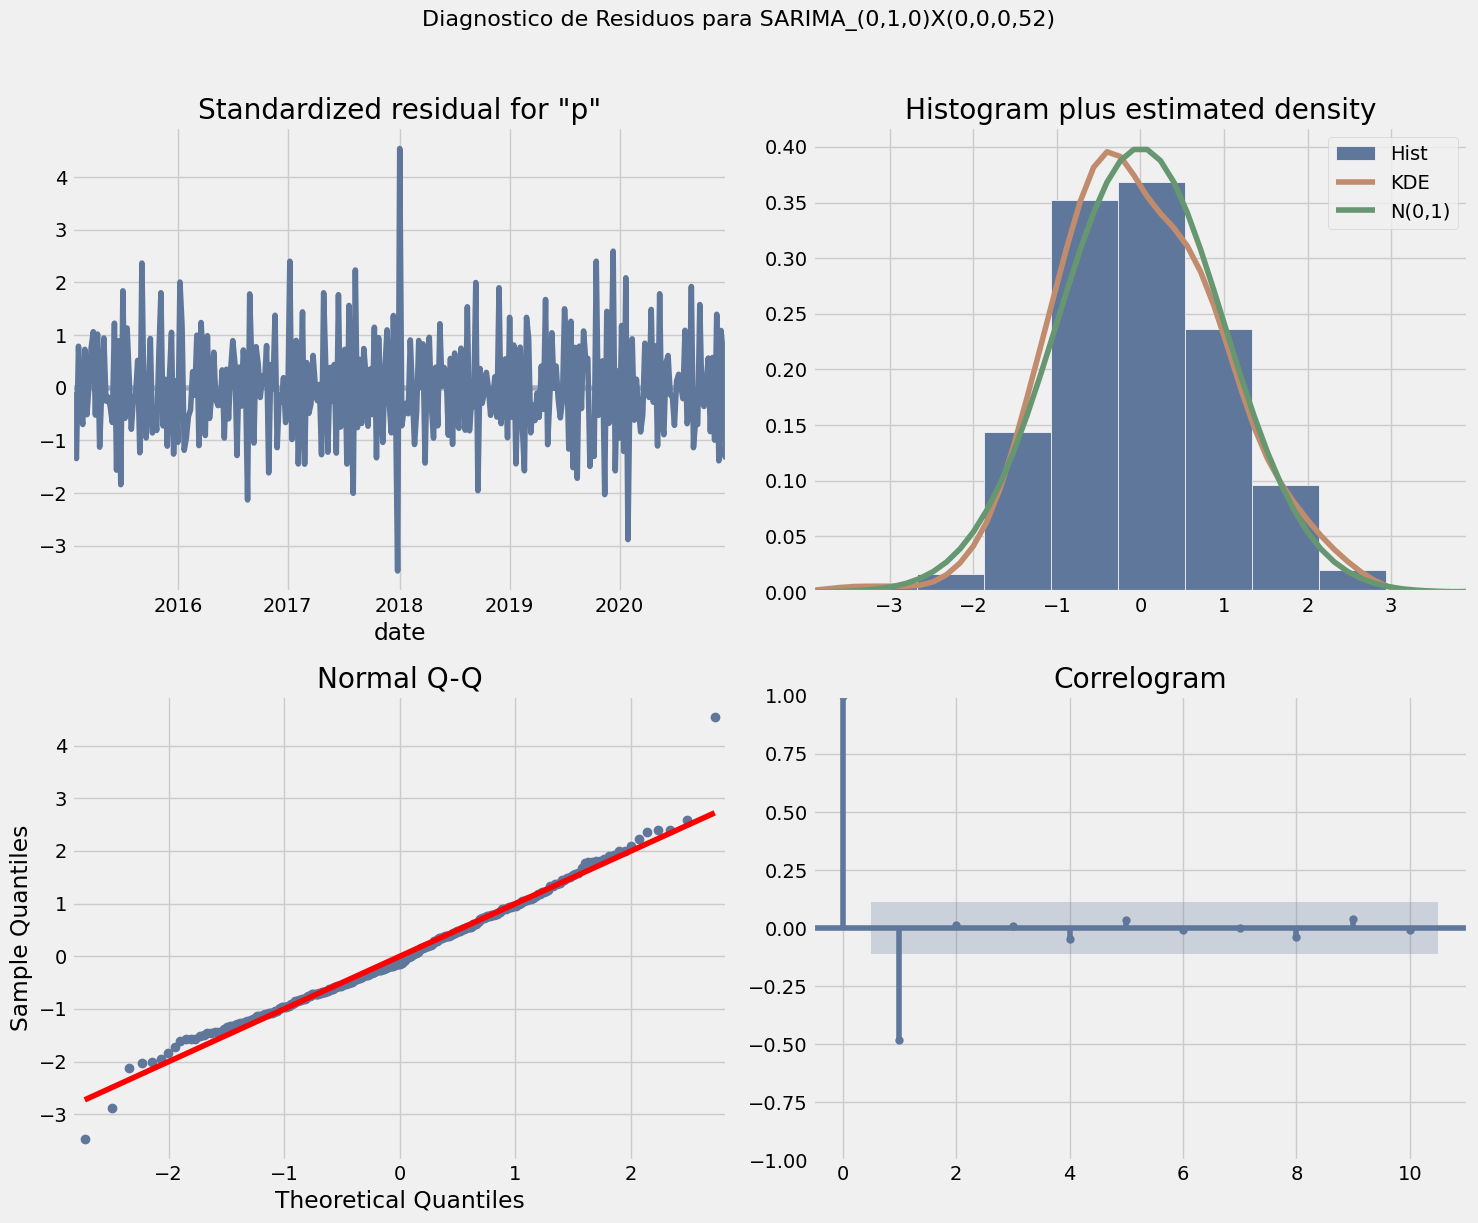

In [9]:
#Validación del modelo: evalúe los residuos del modelo óptimo y determine si se comportan como ruido blanco.
best_params_tuple = ((0, 1, 0), (0, 0, 0, 52))
best_model_name = "SARIMA_(0,1,0)X(0,0,0,52)"
optimal_model = SarimaModels(params=best_params_tuple)
model_fit = optimal_model.fit_model(y=y_s4, date=target_date)

fig = model_fit.plot_diagnostics(figsize=(15, 12))
plt.suptitle(f'Diagnostico de Residuos para {best_model_name}', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Los residuos se acercan mucho al ruido blanco, pero no lo hace de manera perfecta. Los graficos de normalidad (Histograma y Q-Q) son buenos, sin embargo, el Correlograma muestra que el lag 1 es estadísticamente significativo, lo que indica que aun queda una pequeña cantidad de autocorrelación de corto plazo que el modelo no logró capturar.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [10]:
from prophet import Prophet
# (Asumo que y_s4 y target_date ya existen)
# y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()
df_prophet = y_s4.reset_index()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'pdq': 'y'})

mask_ds = df_prophet['ds'] < target_date
df_train = df_prophet[mask_ds]
df_test = df_prophet[~mask_ds]

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_prophet.fit(df_train)

In [11]:
import sys
!{sys.executable} -m pip uninstall prophet -y

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1


In [12]:
import sys
!{sys.executable} -m pip install prophet cmdstanpy

  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)


In [15]:
future_dates = model_prophet.make_future_dataframe(periods=len(df_test), freq='W')
forecast = model_prophet.predict(future_dates)
preds_prophet = forecast.set_index('ds').loc[target_date:]['yhat']

df_test_prophet = pd.DataFrame({
    'y': df_test.set_index('ds')['y'],
    'yhat': preds_prophet
})
metrics_prophet = summary_metrics(df_test_prophet)
metrics_prophet['model'] = 'Prophet'
metrics_sarima = df_all_metrics_sorted.iloc[0:1].copy()
df_compare = pd.concat([metrics_sarima, metrics_prophet]).reset_index(drop=True)
print(df_compare[['model', 'mae', 'rmse', 'mape']])

                       model     mae    rmse    mape
0  SARIMA_(0,1,0)X(0,0,0,52)  2.2015  2.5642  0.0826
1                    Prophet  2.6798  3.3581  0.1044


Notemos que para la prediccion,** SARIMA es bueno**, ya que la configuracion SARIMA_(0,1,0)X(0,0,0,52) fue el mas preciso en todas las metricas, sin embargo, **en terminos de facilidad para implementar, Prophet es el mejor**, solo se necesita renombrar columnas (ds, y) y llamar a .fit(), mientras que **SARIMA necesita una combinacion de 64 modelos diferentes de parametros** y un analisis manual. Las diferencias en los supuestos de ambos modelos se tienen en que **SARIMA es un modelo estadistico que asume estacionariedad**, mientras que **Prophet es un modelo descompone la serie en sus partes** (tendencia, estacionalidad) y asume que se suman,ademas, maneja tendencias no lineales automaticamente.

En conclusion, **se debe usar Prophet** si se necesita un **pronostico bueno** y **rapido** y **si se tieneN multiples estacionalidades o la tendencia no es lineal**. Por otro lado, **se debe usar SARIMA** si **la precision es la maxima prioridad**, con harto tiempo para analizar y **la serie tiene patrones de autocorrelación claros y estables**.